<a href="https://colab.research.google.com/github/monshri/vgae_over_summer/blob/master/VGAE_TRAIN_TEST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Train and Test is having a division of [35,5] (Total 40 samples for flexion)

import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import numpy as np
from numpy import genfromtxt
import networkx as nx
from scipy import sparse
import scipy.sparse as sp
import torch
import torch.nn.functional as F
from torch.optim import Adam
from sklearn.metrics import roc_auc_score, average_precision_score
import scipy.sparse as sp
import numpy as np
import os
import time
from scipy import sparse
from numpy import genfromtxt
from scipy.stats import norm
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import glob
from sklearn.cluster import KMeans

# Dataset creation and Division

dataset = np.zeros((40,150,154))
i = -1
for name in glob.glob('/content/drive/My Drive/COMBINED-WITH-BAD/FLEX/AdjF_flex*'):
	i=i+1
	dataset[i,:,:] = genfromtxt(name, delimiter=',')


train_set, test_set = torch.utils.data.random_split(dataset,[35, 5])

# Shuffle and divide the data into train and test
trainloader = torch.utils.data.DataLoader(dataset = train_set, shuffle=True)
testloader =  torch.utils.data.DataLoader(dataset = test_set, shuffle=False)

In [ ]:
## Model Definition
class VGAE(nn.Module):
	def __init__(self):
		super(VGAE,self).__init__()
		self.base_gcn = GraphConvSparse(150, 16)
		self.gcn_mean = GraphConvSparse(16, 2, activation=lambda x:x)
		self.gcn_logstddev = GraphConvSparse(16, 2, activation=lambda x:x)

	def encode(self, adj, X):
		hidden = self.base_gcn(adj,X)
		self.mean = self.gcn_mean(adj,hidden)
		self.logstd = self.gcn_logstddev(adj,hidden)
    # Gaussian Noise that we create
		gaussian_noise = torch.randn(X.size(0), 2)
    # This is the z distribution that we get z = mu + sigma*noise
		sampled_z = gaussian_noise*torch.exp(self.logstd) + self.mean
		return sampled_z

	def forward(self, adj, X):
		Z = self.encode(adj,X)
		A_pred = dot_product_decode(Z)
		return A_pred,Z

# Creating Graph Convolution Module		
class GraphConvSparse(nn.Module):
	def __init__(self, input_dim, output_dim, activation = F.relu, **kwargs):
		super(GraphConvSparse, self).__init__(**kwargs)
    # This will initialise the weights of the network
		self.weight = glorot_init(input_dim, output_dim)
		self.activation = activation

# This part will do the multiplication of AXW0
	def forward(self, adj, inputs):
		x = inputs
		x = torch.mm(x,self.weight.double())
		x = torch.mm(adj, x)
		outputs = self.activation(x)
		return outputs

# This is responsible for decoding
def dot_product_decode(Z):
	A_pred = torch.sigmoid(torch.matmul(Z,Z.t()))
	return A_pred

# This is for initliasation. The dimensions would be given in the argument
def glorot_init(input_dim, output_dim):
	init_range = np.sqrt(6.0/(input_dim + output_dim))
	initial = torch.rand(input_dim, output_dim)*2*init_range - init_range
	return nn.Parameter(initial)

# Responsible for Normalisation of Adjacency matrix
def preprocess_graph(adj):
    adj_ = sp.coo_matrix(adj)
    rowsum = np.array(adj_.sum(1))
    degree_mat_inv_sqrt = sp.diags(np.power(rowsum, -0.5).flatten())
    adj_normalized = adj_.dot(degree_mat_inv_sqrt).transpose().dot(degree_mat_inv_sqrt).tocoo()
    return adj_normalized 


def get_acc(adj_rec, adj_label):
    labels_all = adj_label.view(-1).long()
    preds_all = (adj_rec>0.5).view(-1).long()
    accuracy = (preds_all == labels_all).sum().float() / labels_all.size(0)
    #print((preds_all == labels_all).sum().float())
    return accuracy		

model = VGAE()
optimizer = Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()		

In [ ]:
# Train the data
threshold = 0.5
train_loss = []
acc = []
def train(no_epoch):
  model.train()
  for epoch in range(no_epoch):
    for batch,data in enumerate(trainloader):      
      a = data[0,:,0:150]
      b = data[0,:,0:150]
      a[a<0]=0
      a[np.abs(a)>=threshold]=1
      a[np.abs(a)<threshold]=0
      A = sparse.csr_matrix(a)
      A_norm = preprocess_graph(A)
      A_norm = torch.from_numpy(A_norm.todense())
      A_label = torch.from_numpy(A.todense())
      features = sparse.csr_matrix(b)
      features = torch.from_numpy(features.todense())
      A_pred,Z = model(A_norm,features)
      optimizer.zero_grad()
      loss = criterion(A_pred.view(-1), A_label.view(-1))
      kl_divergence = 0.5/ A_pred.size(0) * (1 + 2*model.logstd - model.mean**2 - torch.exp(model.logstd)).sum(1).mean()
      loss -= kl_divergence
      train_loss.append(loss)
      loss.backward()
      optimizer.step()
      train_acc = get_acc(A_pred,A_label)
      acc.append(train_acc) 
    print("Epoch:", '%04d' % (epoch + 1), "train_loss=", "{:.5f}".format(loss.item()),"train_acc=", "{:.5f}".format(train_acc))
  print("End of Training")
  plt.plot(train_loss)
  plt.ylabel('loss plot')
  plt.show()
  plt.plot(acc)
  plt.ylabel('accuracy plot')
  plt.show()
  print("Mean train loss",sum(train_loss) / len(train_loss) )
  print("Mean train accuracy",sum(acc) / len(acc))


In [ ]:
# Clustering for test samples
def Clustering(Z):
  for batch,data in enumerate(testloader):
    a = data[0,:,0:150]
    X = Z[batch,:,:]
    kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
    A_Zlabels = kmeans.labels_
    print(A_Zlabels)
    color_map = []
    G = nx.from_numpy_matrix(a.numpy())
    plt.figure(1)
    nx.draw(G)
    count_red = 0
    count_blue = 0
    count_green = 0
    for node in G:
      if A_Zlabels[node]==1:
        color_map.append('red')
        count_red = count_red + 1 
      elif A_Zlabels[node]==2:
          color_map.append('blue')
          count_blue = count_blue + 1
      else:
         color_map.append('green')  
         count_green = count_green + 1  

    print("Red Nodes",count_red) 
    print("Blue Nodes",count_blue)    
    print("Green Nodes",count_green)
    plt.figure(2)       
    nx.draw(G, node_color=color_map, with_labels=True)
    plt.show()

In [ ]:
# Test the model
def test():
  threshold = 0.5
  test_loss = []
  Testacc = []
  Z_test = np.zeros((5,150,2))
  for batch,data in enumerate(testloader):
    a = data[0,:,0:150]
    b = data[0,:,0:150]
    a[a<0]=0
    a[np.abs(a)>=threshold]=1
    a[np.abs(a)<threshold]=0
    A = sparse.csr_matrix(a)
    A_norm = preprocess_graph(A)
    A_norm = torch.from_numpy(A_norm.todense())
    A_label = torch.from_numpy(A.todense())
    features = sparse.csr_matrix(b)
    features = torch.from_numpy(features.todense())
    A_pred,Z = model(A_norm,features) 
    Z_test[batch,:,:]=Z.detach().numpy()   
    loss = log_lik = criterion(A_pred.view(-1), A_label.view(-1))
    kl_divergence = 0.5/ A_pred.size(0) * (1 + 2*model.logstd - model.mean**2 - torch.exp(model.logstd)).sum(1).mean()
    loss -= kl_divergence
    test_loss.append(loss)
    test_acc = get_acc(A_pred,A_label)
    Testacc.append(test_acc) 
    print( "test_loss=", "{:.5f}".format(loss.item()),"test_acc=", "{:.5f}".format(test_acc))
  plt.plot(test_loss)
  plt.ylabel('loss plot for test')
  plt.show()
  plt.plot(Testacc)
  plt.ylabel('accuracy plot for test')
  plt.show()
  print("Mean test loss",sum(test_loss) / len(test_loss) )
  print("Mean test accuracy",sum(Testacc) / len(Testacc))
  return Z_test

Epoch: 0001 train_loss= 0.12408 train_acc= 0.89067
Epoch: 0002 train_loss= 0.18332 train_acc= 0.79387
Epoch: 0003 train_loss= 0.11578 train_acc= 0.86533
Epoch: 0004 train_loss= 0.12459 train_acc= 0.84622
Epoch: 0005 train_loss= 0.12341 train_acc= 0.85084
Epoch: 0006 train_loss= 0.12694 train_acc= 0.91680
Epoch: 0007 train_loss= 0.11166 train_acc= 0.88924
Epoch: 0008 train_loss= 0.12572 train_acc= 0.87324
Epoch: 0009 train_loss= 0.11151 train_acc= 0.86996
Epoch: 0010 train_loss= 0.11535 train_acc= 0.87316
Epoch: 0011 train_loss= 0.10678 train_acc= 0.88142
Epoch: 0012 train_loss= 0.11269 train_acc= 0.86720
Epoch: 0013 train_loss= 0.10775 train_acc= 0.90507
Epoch: 0014 train_loss= 0.08962 train_acc= 0.91884
Epoch: 0015 train_loss= 0.09242 train_acc= 0.91760
Epoch: 0016 train_loss= 0.09309 train_acc= 0.91716
Epoch: 0017 train_loss= 0.09044 train_acc= 0.92738
Epoch: 0018 train_loss= 0.09703 train_acc= 0.91298
Epoch: 0019 train_loss= 0.08934 train_acc= 0.91307
Epoch: 0020 train_loss= 0.09531

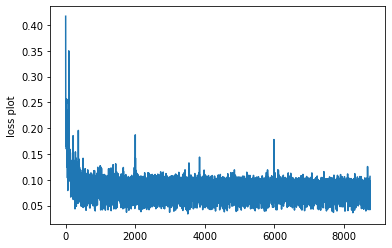

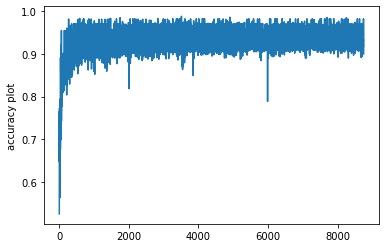

Mean train loss tensor(0.0923, dtype=torch.float64, grad_fn=<DivBackward0>)
Mean train accuracy tensor(0.9205)
test_loss= 0.09573 test_acc= 0.91369
test_loss= 0.11944 test_acc= 0.88622
test_loss= 0.09295 test_acc= 0.91911
test_loss= 0.09475 test_acc= 0.92667
test_loss= 0.08157 test_acc= 0.93253


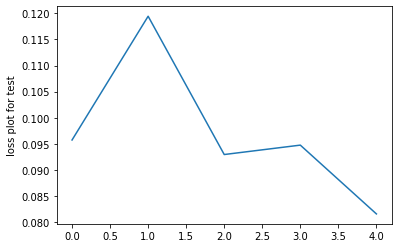

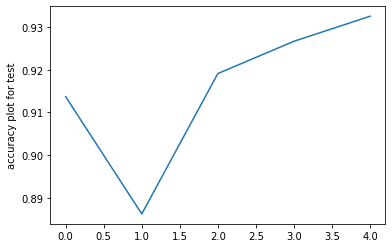

Mean test loss tensor(0.0969, dtype=torch.float64, grad_fn=<DivBackward0>)
Mean test accuracy tensor(0.9156)
[0 0 0 0 0 0 2 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 0 0 0 0 0 0 0 0 2
 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 2 1 1 2 2 0 0
 0 0 1 1 1 1 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 1 1 1 1 0 0
 0 0 0 0 0 1 1 2 2 0 0 0 0 0 2 0 2 0 2 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0
 0 0]
Red Nodes 23
Blue Nodes 15
Green Nodes 112


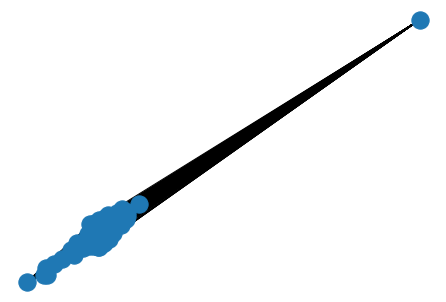

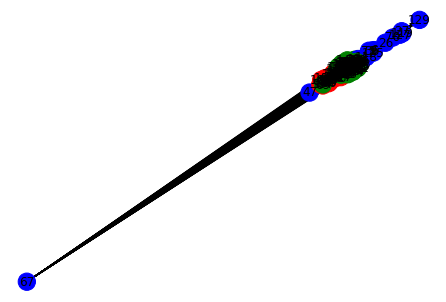

[0 0 2 0 0 2 2 0 2 1 0 0 0 0 0 0 0 2 2 2 0 0 0 0 2 0 1 1 0 0 0 0 0 2 0 0 1
 0 2 2 0 0 0 0 0 2 0 1 0 2 0 0 0 0 0 2 2 2 2 2 0 0 2 0 0 0 2 1 2 2 1 1 0 0
 2 0 2 2 2 2 0 0 0 0 0 2 2 2 2 2 0 0 2 0 0 0 2 2 2 2 0 0 0 0 0 2 2 2 2 0 0
 0 0 0 0 2 2 2 1 1 0 0 0 0 0 2 2 0 0 1 0 0 0 0 0 0 2 0 0 1 0 0 0 0 2 2 2 2
 2 2]
Red Nodes 12
Blue Nodes 53
Green Nodes 85


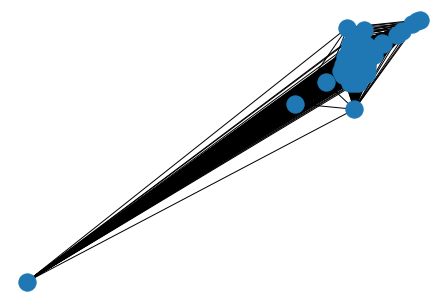

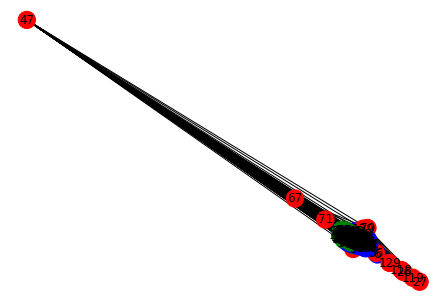

[0 0 0 0 0 0 2 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 0 0 0 0 0 0 0 0 2
 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 2 1 1 2 2 0 0
 0 0 1 1 1 1 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 1 1 1 0 0 0
 0 0 0 0 0 1 1 2 2 0 0 0 0 0 2 1 2 0 2 0 0 0 0 0 0 2 1 0 0 0 0 0 0 0 0 2 0
 0 0]
Red Nodes 23
Blue Nodes 16
Green Nodes 111


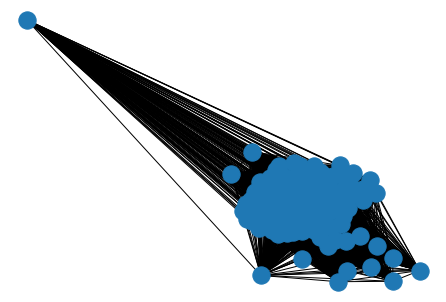

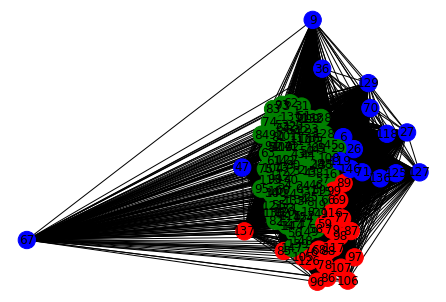

[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 1
 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 1 2 2 1 1 0 0
 0 0 0 2 2 2 0 0 0 0 0 0 2 2 2 2 0 0 0 0 0 0 2 2 2 2 0 0 0 0 0 0 2 2 2 0 0
 0 0 0 0 0 0 2 1 2 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 1 1
 0 0]
Red Nodes 21
Blue Nodes 19
Green Nodes 110


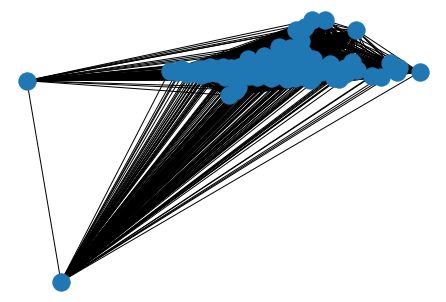

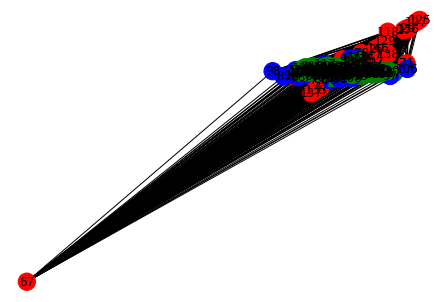

[0 0 0 0 0 0 0 0 2 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1
 0 0 2 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 1 1 0 0
 0 0 0 2 2 2 0 0 0 0 0 0 2 2 2 2 0 0 0 0 0 0 2 2 2 2 0 0 0 0 0 0 2 2 2 0 0
 0 0 0 0 0 2 2 1 1 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 2 1 0 0 2 0 0 0 0 0 0 1 0
 0 0]
Red Nodes 15
Blue Nodes 22
Green Nodes 113


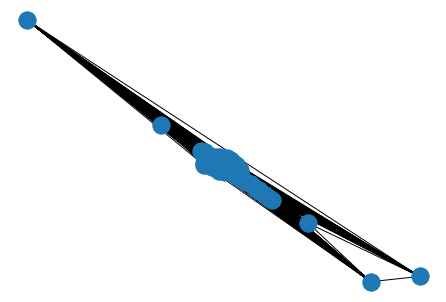

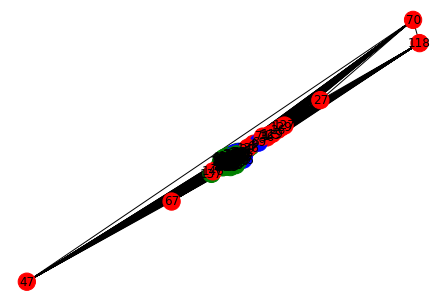

In [ ]:
train(250)
Z_test_samples = test()
Clustering(Z_test_samples)